# importing libraries

In [1]:
## We first load in packages we will need
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
sns.set_style("whitegrid")
import re

# Loading data

In [2]:
cars = pd.read_csv('data_model.csv')

In [3]:
df_cars = cars.copy()  #makinga copy of original data set

print('Original Data Shape:',df_cars.shape)


Original Data Shape: (3813, 41)


Metric	    Target Range

MAE	          2,000–8,000

RMSE	      3,000–12,000

MAPE	      ≤15% (across all prices)

R² Score	  >0.80, ideally >0.85

# Dropping unwanted and unimportant columns

In [4]:
df_cars.columns

Index(['brand', 'model', 'model_year', 'fuel_type', 'transmission', 'ext_col',
       'int_col', 'accident', 'clean_title', 'price', 'years_used', 'capacity',
       'horsepower', 'cylinder_count', 'mileage_per_year', 'mileage_sqrt',
       'mileage_with_age', 'mileage_per_year_with_age', 'mileage_brand',
       'mileage', 'brand_category', 'log_price', 'power_to_weight_ratio',
       'brand_frequency', 'model_frequency', 'brand_target_enc',
       'model_target_enc', 'mileage_per_year_sqrt', 'mileage_times_age',
       'mileage_sqrt_times_age', 'horsepower_times_cylinder_count',
       'capacity_mileage_interaction', 'age_squared', 'mileage_binned',
       'log_mileage', 'log_capacity', 'capacity_binned', 'horsepower_binned',
       'age_binned', 'trans_num', 'brand_enc'],
      dtype='object')

# KNN

In [5]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


In [6]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Function to perform KNN regression
def perform_knn_regression(df, target_column):
    # Splitting the data into features (X) and target (y)
    X = df.drop(target_column, axis=1)
    y = df[target_column]
    
    # Train-test split (80% training, 20% testing)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Initialize KNN Regressor
    knn = KNeighborsRegressor()

    # Fit the model on the training data
    knn.fit(X_train_scaled, y_train)

    # Predict on the test data
    y_pred = knn.predict(X_test_scaled)

    # Exponentiate to get the original price scale (since log_price was used)
    y_pred_original = np.exp(y_pred)
    y_test_original = np.exp(y_test)

    # Calculate MAE, MSE, RMSE, and R² for actual prices
    mae_actual = mean_absolute_error(y_test_original, y_pred_original)
    mse_actual = mean_squared_error(y_test_original, y_pred_original)
    rmse_actual = np.sqrt(mse_actual)
    r2_actual = r2_score(y_test_original, y_pred_original)

    # Relative Metrics for actual prices
    mape_actual = np.mean(np.abs((y_test_original - y_pred_original) / y_test_original)) * 100
    smape_actual = np.mean(2 * np.abs(y_test_original - y_pred_original) / (np.abs(y_test_original) + np.abs(y_pred_original))) * 100

    # Results
    results = {
        "MAE (Actual Price)": mae_actual,
        "MSE (Actual Price)": mse_actual,
        "RMSE (Actual Price)": rmse_actual,
        "R² Score (Actual Price)": r2_actual,
        "MAPE (mean of absolute percentage error)": mape_actual,
        "sMAPE (same as mape but avoids division by 0)": smape_actual
    }

    return results, y_pred, y_test


In [ ]:
# Assuming df is your DataFrame with 'log_price' as the target column
col1 = ['fuel_type', 'transmission', 'capacity_binned', 'mileage_sqrt', 'years_used', 
        'log_price', 'brand', 'horsepower', 'brand_frequency']
col =['fuel_type', 'brand','model_frequency','brand_frequency','transmission','years_used', 'capacity_binned','horsepower', 'cylinder_count','log_mileage', 'brand_category', 'log_price']
df_knn = df_cars[col1]

# Apply one-hot encoding for categorical columns (if applicable)
categorical_columns = df_knn.select_dtypes(include=['object', 'category']).columns.to_list()
df_knn = pd.get_dummies(df_knn, columns=categorical_columns, drop_first=True)

# Run KNN regression
results_knn, y_pred_knn, y_test_knn = perform_knn_regression(df_knn, target_column='log_price')
for metric, value in results_knn.items():
    print(f"{metric}: {value}")

MAE (Actual Price): 9747.941645970748
MSE (Actual Price): 330689135.9283956
RMSE (Actual Price): 18184.86007447942
R² Score (Actual Price): 0.7703487744337402
MAPE (mean of absolute percentage error): 30.22061256545342
sMAPE (same as mape but avoids division by 0): 26.988505890543667


In [13]:
def tune_knn_hyperparameters(df, target_column):
    # Splitting the data into features (X) and target (y)
    X = df.drop(target_column, axis=1)
    y = df[target_column]
    
    # Train-test split (80% training, 20% testing)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=50)

    # Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Create KNN model
    knn = KNeighborsRegressor()

    # Define hyperparameters for tuning
    param_grid = {
        'n_neighbors': [3, 5, 7, 10, 15],  # Number of neighbors
        'weights': ['uniform', 'distance'],  # Weighting method
        'metric': ['euclidean', 'manhattan', 'minkowski']  # Distance metric
    }

    # Use GridSearchCV to tune hyperparameters
    grid_search = GridSearchCV(knn, param_grid, cv=5, n_jobs=-1, verbose=2)
    grid_search.fit(X_train_scaled, y_train)

    # Get the best parameters and the best score
    print("Best Hyperparameters:", grid_search.best_params_)
    print("Best Cross-validation Score:", grid_search.best_score_)

    # Use the best model for evaluation
    best_knn = grid_search.best_estimator_
    y_pred = best_knn.predict(X_test_scaled)

    # Exponentiate to get the original price scale (since log_price was used)
    y_pred_original = np.exp(y_pred)
    y_test_original = np.exp(y_test)

    # Calculate MAE, MSE, RMSE, and R² for actual prices
    mae_actual = mean_absolute_error(y_test_original, y_pred_original)
    mse_actual = mean_squared_error(y_test_original, y_pred_original)
    rmse_actual = np.sqrt(mse_actual)
    r2_actual = r2_score(y_test_original, y_pred_original)

    # Relative Metrics for actual prices
    mape_actual = np.mean(np.abs((y_test_original - y_pred_original) / y_test_original)) * 100
    smape_actual = np.mean(2 * np.abs(y_test_original - y_pred_original) / (np.abs(y_test_original) + np.abs(y_pred_original))) * 100

    # Results
    results = {
        "MAE (Actual Price)": mae_actual,
        "MSE (Actual Price)": mse_actual,
        "RMSE (Actual Price)": rmse_actual,
        "R² Score (Actual Price)": r2_actual,
        "MAPE (mean of absolute percentage error)": mape_actual,
        "sMAPE (same as mape but avoids division by 0)": smape_actual
    }

    return results, y_pred, y_test

# Tuning KNN hyperparameters
results, y_pred, y_test = tune_knn_hyperparameters(df_knn, target_column='log_price')
for metric, value in results.items():
    print(f"{metric}: {value}")

Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV] END ...metric=euclidean, n_neighbors=3, weights=uniform; total time=   0.0s
[CV] END ...metric=euclidean, n_neighbors=3, weights=uniform; total time=   0.0s
[CV] END ...metric=euclidean, n_neighbors=3, weights=uniform; total time=   0.0s
[CV] END ...metric=euclidean, n_neighbors=3, weights=uniform; total time=   0.0s
[CV] END ...metric=euclidean, n_neighbors=3, weights=uniform; total time=   0.0s
[CV] END ..metric=euclidean, n_neighbors=3, weights=distance; total time=   0.0s
[CV] END ..metric=euclidean, n_neighbors=3, weights=distance; total time=   0.0s
[CV] END ..metric=euclidean, n_neighbors=3, weights=distance; total time=   0.1s
[CV] END ...metric=euclidean, n_neighbors=5, weights=uniform; total time=   0.0s
[CV] END ..metric=euclidean, n_neighbors=3, weights=distance; total time=   0.1s
[CV] END ...metric=euclidean, n_neighbors=5, weights=uniform; total time=   0.0s
[CV] END ..metric=euclidean, n_neighbors=3, wei

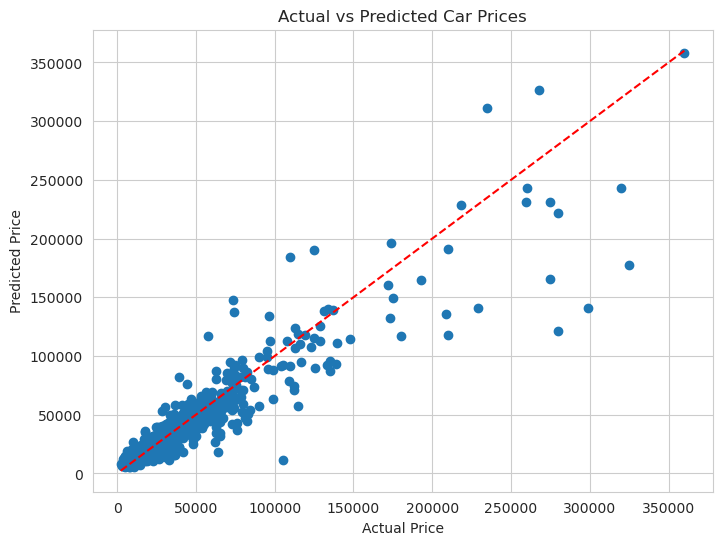

In [14]:
y_pred_original = np.exp(y_pred)
y_test_original = np.exp(y_test)
residuals = y_test - y_pred
plt.figure(figsize=(8, 6))
plt.scatter(y_test_original, y_pred_original)
plt.plot([min(y_test_original), max(y_test_original)], [min(y_test_original), max(y_test_original)], color='red', linestyle='--')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual vs Predicted Car Prices')
plt.savefig('KNN_price_comparison.png')
plt.show()

In [15]:
mean_residual = np.mean(residuals)
std_residual = np.std(residuals)
outlier_mask = (residuals > mean_residual + 3 * std_residual) | (residuals < mean_residual - 3 * std_residual)


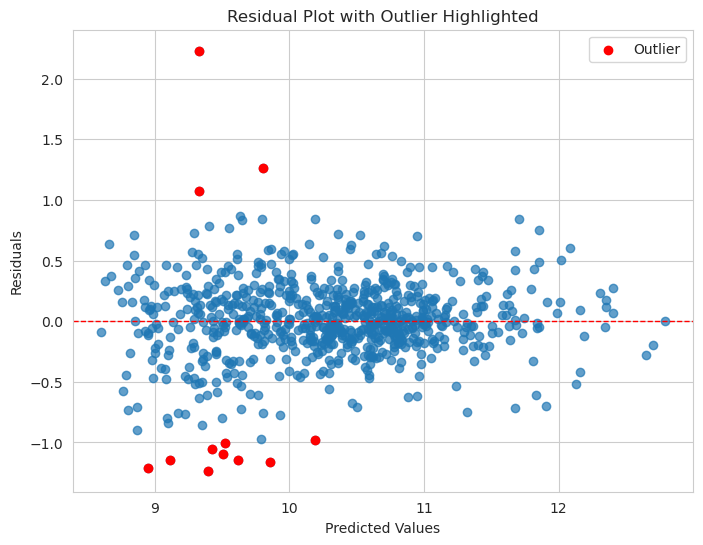

In [16]:
plt.figure(figsize=(8, 6))
plt.scatter(y_pred, residuals, alpha=0.7)
plt.scatter(y_pred[outlier_mask], residuals[outlier_mask], color='red', label='Outlier')
plt.axhline(0, color='red', linestyle='--', linewidth=1)
plt.legend()
plt.title("Residual Plot with Outlier Highlighted")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.savefig('KNN_residuals.png')
plt.show()

In [17]:
# Remove the outlier
y_test_filtered = y_test[~outlier_mask]
y_pred_filtered = y_pred[~outlier_mask]


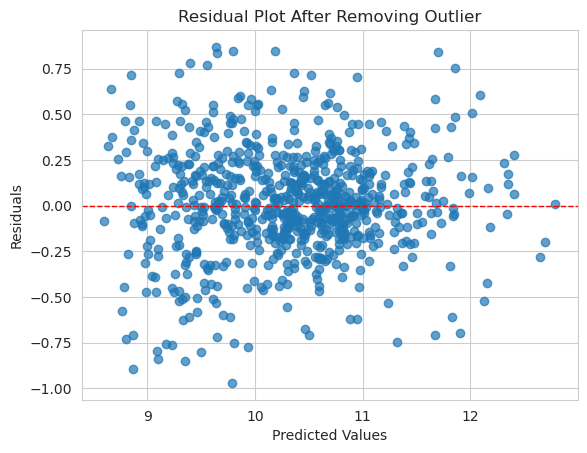

In [18]:
residuals_filtered = y_test_filtered - y_pred_filtered
plt.scatter(y_pred_filtered, residuals_filtered, alpha=0.7)
plt.axhline(0, color='red', linestyle='--', linewidth=1)
plt.title("Residual Plot After Removing Outlier")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.show()

In [19]:
outlier_indices = np.where(outlier_mask)[0]
print("Outlier Indices:", outlier_indices)

Outlier Indices: [ 28 211 308 332 393 454 476 484 510 707 715 750]


In [20]:
# Assuming your dataset is in a DataFrame called df
outlier_data = df_knn.iloc[outlier_indices]
print("Outlier Data Points:")
print(outlier_data)

Outlier Data Points:
     capacity_binned  mileage_sqrt  years_used  log_price  horsepower  \
28               2.0    286.146815         7.0   9.970024  331.515805   
211              2.0    298.328678         8.0   9.581973  210.000000   
308              2.0     91.515026         4.0  11.154835  331.515805   
332              2.0    221.546835         8.0   9.980032  331.515805   
393              2.0    146.584447         4.0  10.472941  331.515805   
454              2.0    220.227155         5.0  10.680539  349.000000   
476              4.0     13.964240         1.0  11.379406  310.000000   
484              2.0    168.324092         6.0   9.928229  184.000000   
510              4.0    363.692178        17.0   8.810012  261.000000   
707              4.0     83.666003         1.0  10.736418  285.000000   
715              6.0    148.323970         7.0  12.254868  573.000000   
750              2.0    288.357417        17.0   8.846641  244.000000   

     brand_frequency  fuel_ty

In [21]:
from scipy import stats

# Calculate z-scores
z_scores = stats.zscore(residuals)

# Identify points with z-scores greater than 3 (or less than -3, depending on threshold)
outliers = np.where(np.abs(z_scores) > 3)
print("Outlier indices:", outliers)

Outlier indices: (array([ 28, 211, 308, 332, 393, 454, 476, 484, 510, 707, 715, 750]),)


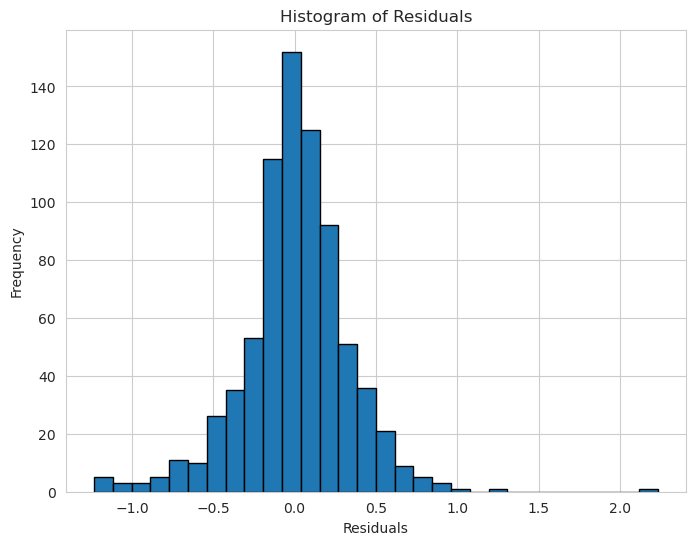

In [22]:
# Histogram of residuals
plt.figure(figsize=(8, 6))
plt.hist(residuals, bins=30, edgecolor='k')
plt.title("Histogram of Residuals")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.savefig('KNN_residual_hist.png')
plt.show()